In [1]:
from fastai import *
from fastai.vision.all import *
from models import conv, deconv

import sys
sys.path.append('..')
from src.band_plotters import *
from src.Tiff32Image import Tiff32Image

In [2]:
NUMBER_OF_NEAR_BANDS = 12
SELECTED_WIDTH = 128

## Load

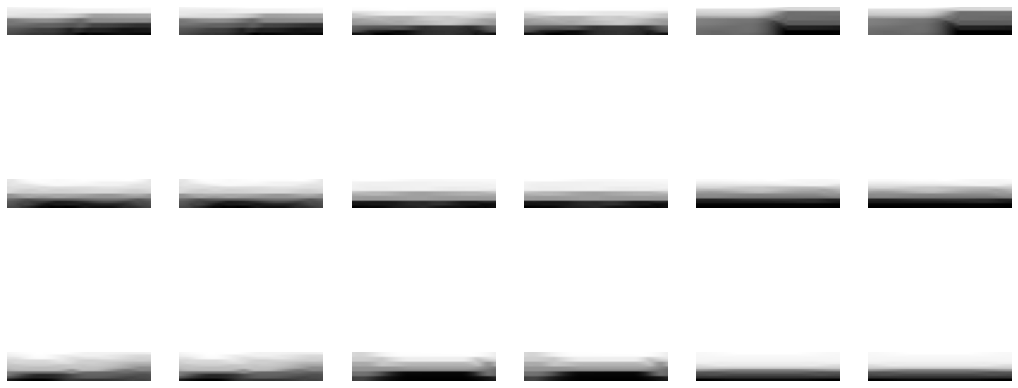

In [3]:
dls = DataBlock(
    blocks=(ImageBlock(cls=Tiff32Image), ImageBlock(cls=Tiff32Image)), 
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.1),
    item_tfms=[Resize((12, 60))],
    batch_tfms=[IntToFloatTensor(div=2**16-1),],
        ).dataloaders(DATA_DIRECTORY/f"images/energies_{NUMBER_OF_NEAR_BANDS}_nearest_bands", bs=16)

dls.show_batch()

## Train

### Create Learner

In [4]:
from models import conv, deconv

class SimpleAutoencoder(nn.Module):
    def __init__(self, n_latent=128):
        super().__init__()
        self.encode = nn.Sequential(
            conv(1, 4), # 12x128
            # conv(4, 8), # 6x64
            # conv(8, 16), # 3x32
            # conv(16, 32), # 33x16
            # nn.Flatten(),
            # nn.Linear(32*33*16, n_latent),
            # nn.Tanh()
        )
        
        # self.decode_linear=nn.Sequential(
        #     nn.Linear(n_latent, 32*33*16),
        #     nn.ReLU()
        # )
        
        self.decode = nn.Sequential(
            # deconv(32, 16), # 32x32
            # deconv(16, 8), # 64x64
            # deconv(8, 4), # 128x128
            deconv(4, 1, act=False), # 256x256
            nn.Sigmoid()
        )
        
    
    def forward(self, x):
        output = self.encode(x)
        # output = self.decode_linear(output)
        # output = output.view(-1, 32, 33, 16)
        return self.decode(output)

In [5]:
ae = SimpleAutoencoder(n_latent=128)
learn = Learner(dls, ae, F.mse_loss, cbs=[ShowGraphCallback()])
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,time


ValueError: Caught ValueError in DataLoader worker process 4.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/fetch.py", line 39, in fetch
    data = next(self.dataset_iter)
  File "/usr/local/lib/python3.9/dist-packages/fastai/data/load.py", line 140, in create_batches
    yield from map(self.do_batch, self.chunkify(res))
  File "/usr/local/lib/python3.9/dist-packages/fastcore/basics.py", line 230, in chunked
    res = list(itertools.islice(it, chunk_sz))
  File "/usr/local/lib/python3.9/dist-packages/fastai/data/load.py", line 155, in do_item
    try: return self.after_item(self.create_item(s))
  File "/usr/local/lib/python3.9/dist-packages/fastcore/transform.py", line 208, in __call__
    def __call__(self, o): return compose_tfms(o, tfms=self.fs, split_idx=self.split_idx)
  File "/usr/local/lib/python3.9/dist-packages/fastcore/transform.py", line 158, in compose_tfms
    x = f(x, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/fastai/vision/augment.py", line 49, in __call__
    return super().__call__(b, split_idx=split_idx, **kwargs) if self.do else b
  File "/usr/local/lib/python3.9/dist-packages/fastcore/transform.py", line 81, in __call__
    def __call__(self, x, **kwargs): return self._call('encodes', x, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/fastcore/transform.py", line 91, in _call
    return self._do_call(getattr(self, fn), x, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/fastcore/transform.py", line 98, in _do_call
    res = tuple(self._do_call(f, x_, **kwargs) for x_ in x)
  File "/usr/local/lib/python3.9/dist-packages/fastcore/transform.py", line 98, in <genexpr>
    res = tuple(self._do_call(f, x_, **kwargs) for x_ in x)
  File "/usr/local/lib/python3.9/dist-packages/fastcore/transform.py", line 97, in _do_call
    return retain_type(f(x, **kwargs), x, ret)
  File "/usr/local/lib/python3.9/dist-packages/fastcore/dispatch.py", line 120, in __call__
    return f(*args, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/fastai/vision/augment.py", line 275, in encodes
    return x.crop_pad(cp_sz, tl, orig_sz=orig_sz, pad_mode=self.pad_mode,
  File "/usr/local/lib/python3.9/dist-packages/fastai/vision/augment.py", line 164, in crop_pad
    return x._do_crop_pad(sz, tl, orig_sz=orig_sz, pad_mode=pad_mode, resize_mode=resize_mode, resize_to=resize_to)
  File "/usr/local/lib/python3.9/dist-packages/fastai/vision/augment.py", line 137, in _do_crop_pad
    x = tvpad(x, (*p, *f), padding_mode=_pad_modes[pad_mode])
  File "/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py", line 479, in pad
    return F_pil.pad(img, padding=padding, fill=fill, padding_mode=padding_mode)
  File "/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional_pil.py", line 222, in pad
    return Image.fromarray(img)
  File "/usr/local/lib/python3.9/dist-packages/PIL/Image.py", line 2974, in fromarray
    return frombuffer(mode, size, obj, "raw", rawmode, 0, 1)
  File "/usr/local/lib/python3.9/dist-packages/PIL/Image.py", line 2901, in frombuffer
    return frombytes(mode, size, data, decoder_name, args)
  File "/usr/local/lib/python3.9/dist-packages/PIL/Image.py", line 2843, in frombytes
    im.frombytes(data, decoder_name, args)
  File "/usr/local/lib/python3.9/dist-packages/PIL/Image.py", line 794, in frombytes
    d.setimage(self.im)
ValueError: tile cannot extend outside image


## View Predictions

In [ ]:
learn.predict()